In [51]:
import numpy as np
from scipy.signal import convolve2d
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.datasets import mnist
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

In [52]:
def construct_adjacency_matrix(X, num_neighbors):
    num_points = X.shape[0]

    # Initialize a zero matrix for adjacency
    adjacency_matrix = np.zeros((num_points, num_points))

    # Create a nearest neighbors finder
    nearest_neighbors = NearestNeighbors(n_neighbors=num_neighbors + 1).fit(X)

    # Find and set edges for each point based on its nearest neighbors
    for i in range(num_points):
        _, neighbors = nearest_neighbors.kneighbors(X, return_distance=True)
        adjacency_matrix[i, neighbors[i, 1:]] = 1  # Skip the first neighbor (the point itself)
        adjacency_matrix[ neighbors[i, 1:],i] = 1

    return adjacency_matrix

In [92]:
X, Y = make_swiss_roll(5000)
#sort data based on Y
idx = np.argsort(Y)
X = X[idx]
#convert to binary
Y[:len(Y)//2] = 0
Y[len(Y)//2:] = 1
#shuffle
idx = np.random.permutation(len(Y))
#revalue
X, Y = X[idx], Y[idx]


n = 8
p = 100
sample_numbers = [50, 100,200, 500,1000]
num_reps = 20


#now find the matrix
W = construct_adjacency_matrix(X, n)
d = np.sum(W, axis=1)
D = np.diag(d)
L = D - W

#get the info from the matrix
eigenvalues, eigenvectors = np.linalg.eig(L)  # Capture both eigenvalues and eigenvectors
eigenvectors = eigenvectors[:, np.argsort(eigenvalues)]  # Sort eigenvectors based on eigenvalues
e = eigenvectors[:, :p]  # Select the first `p` eigenvectors


def test_accuracy_manifold(e, s, p, labels):
    E = e[:s]
    conf = []
    for label in np.unique(labels):
        Y = np.copy(labels)
        Y[labels == label] = 1
        Y[labels != label] = -1

        a = np.linalg.inv(np.dot(E.T, E))@E.T@Y[:s]

        value = e[s:] @ a;
        conf.append(value.tolist())

    conf = np.array(conf)
    pred_labels = np.argmax(conf, axis=0)
    return np.mean(pred_labels != labels[s:])

mean_error_list = np.zeros((len(sample_numbers), 1))
std_error_list = np.zeros((len(sample_numbers), 1))

for i, s in enumerate(sample_numbers):
    errors = []
    for _ in range(num_reps):
        error = test_accuracy_manifold(e, s, p, Y)
        errors.append(error)
    mean_error_list[i] = np.mean(errors)
    std_error_list[i] = np.std(errors)


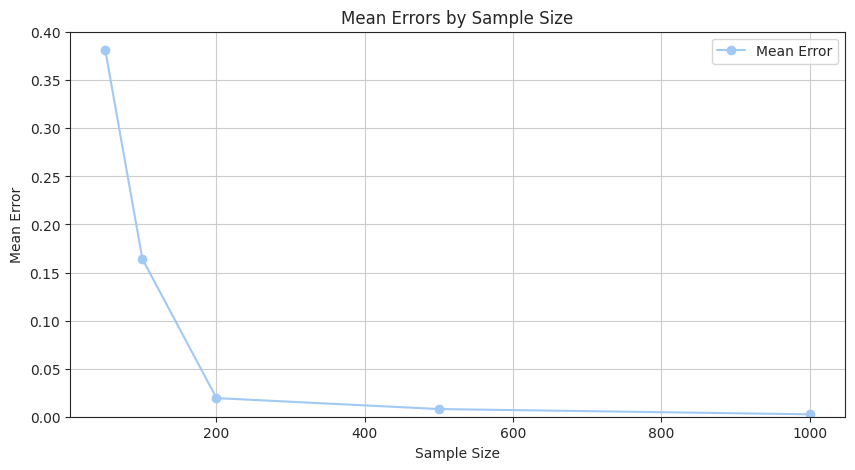

In [104]:

mean_error_list = mean_error_list.reshape(len(sample_numbers))


# Assuming sample_sizes and the error arrays are defined above
sample_sizes = sample_numbers

# Plotting the mean errors with a line plot
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, mean_error_list, marker='o', label='Mean Error')

# Adding titles and labels
plt.title('Mean Errors by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Mean Error')
plt.legend()

# Set the lower limit of the y-axis to 0
plt.ylim(bottom=0)

# Show grid and the plot
plt.grid(True)
plt.show()

